# Wine GGH Expansion Benchmark (Cleaned)

This notebook contains only the necessary code to run the GGH expansion benchmark.

**Results**: Partial R2 ≈ 0.18, GGH R2 ≈ 0.235


In [32]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [33]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid Iterative"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']

# Hypothesis values (3-class)
hypothesis = [[9.4, 10.5, 12.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 1
lr = 0.001

# Iteration 1 parameters
iter1_epochs = 60
iter1_analysis_epochs = 5  # Track last 5 epochs

# Iteration 2 parameters
iter2_epochs = 30  # Same training duration
top_percentile = 30  # Use top 30% from Iteration 1
partial_target_ratio = 0.25  # Partial should be ~25% of effective training

# Iteration 3 parameters
iter3_analysis_epochs = 5  # Track last 5 epochs for remaining data

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['iteration1', 'iteration2', 'iteration3']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Iteration 1: {iter1_epochs} epochs (track last {iter1_analysis_epochs})")
print(f"Iteration 2: {iter2_epochs} epochs on top {top_percentile}% + weighted partial")
print(f"Iteration 3: Score remaining {100-top_percentile}% with biased model")
print(f"Hypothesis values: {hypothesis[0]}")

Results will be saved to: ../saved_results/Red Wine Hybrid Iterative
Iteration 1: 60 epochs (track last 5)
Iteration 2: 30 epochs on top 30% + weighted partial
Iteration 3: Score remaining 70% with biased model
Hypothesis values: [9.4, 10.5, 12.0]


## Model Definitions

In [34]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


## Training Classes

In [35]:
class UnbiasedTrainer:
    """
    Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    Used for Iteration 1.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("UnbiasedTrainer defined.")

UnbiasedTrainer defined.


In [36]:
class BiasedTrainer:
    """
    Train on selected hypotheses + weighted partial data.
    Used for Iteration 2.
    """
    def __init__(self, DO, model, selected_gids, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.selected_gids = set(selected_gids)  # Top N% from Iteration 1
        self.partial_gids = set(partial_gids)    # Partial data (known correct)
        self.partial_weight = partial_weight
        
        # Tracking data for analysis
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on selected + partial data."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Compute individual losses
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Apply weights: selected gets weight 1, partial gets partial_weight
            weights = torch.zeros(len(inputs), device=self.device)
            included_indices = []
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                    included_indices.append(i)
                elif gid in self.selected_gids:
                    weights[i] = 1.0
                    included_indices.append(i)
            
            if len(included_indices) == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Track data if requested
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results."""
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("BiasedTrainer defined.")

BiasedTrainer defined.


In [37]:
class RemainingDataScorer:
    """
    Score remaining data (not used in Iteration 2) using a biased model.
    Computes both loss and gradient signals.
    Used for Iteration 3.
    """
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        # Storage for scores
        self.loss_scores = {}  # gid -> avg_loss
        self.gradient_history = {}  # gid -> list of gradients
        
    def compute_scores(self, dataloader, n_passes=5):
        """
        Compute loss and gradient scores for remaining data.
        Run multiple passes to get stable gradient estimates.
        """
        self.model.eval()
        criterion = nn.MSELoss(reduction='none')
        
        for pass_idx in tqdm(range(n_passes), desc="Scoring passes"):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    # Only score remaining samples
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    # Compute loss
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    # Store loss
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    # Compute gradient
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
        
        print(f"Scored {len(self.loss_scores)} hypotheses from {len(self.remaining_sample_indices)} samples")
    
    def get_analysis(self):
        """Get analysis for scored hypotheses."""
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("RemainingDataScorer defined.")

RemainingDataScorer defined.


## Utilities

In [38]:
def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

print("Adaptive context utilities loaded.")

Adaptive context utilities loaded.


## GGH Expansion Benchmark

BENCHMARK: GGH Soft Weight Refinement vs Partial-Only
GGH Method (Soft Weighting - No Hard Pruning):
  Iter1: 60 epochs unbiased (lr=0.01), last 5 tracked
  Iter1: Enriched scoring -> soft weights (min=0.1, temp=1.0)
  Iter2: 30 epochs weighted training (lr=0.01, pw=2.0)
  Iter3: Biased rescoring -> multiply weights (temp=0.8)
  Iter4: Loss-based adjustment (influence=0.25)
  Final: Train with refined weights + dynamic partial
Partial: Train only on partial data (~2.5%)
Both: 200 epochs, validation-based epoch selection, same architecture

RUN 1/15 (rand_state=42)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 39.2%, class dist: {0: 396, 1: 262, 2: 465}
    Avg weight correct: 0.548, incorrect: 0.556


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.497, incorrect: 0.490
  Iter4 (after loss adj): Avg weight correct: 0.441, incorrect: 0.433
  Unweighted precision: 39.2%, Effective (weighted) precision: 39.6%
  Dynamic partial_weight: 3.13
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0167, test_loss=0.0156, test_mae=0.0946, R2=0.4035
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0176, test_loss=0.0172, test_mae=0.0982, R2=0.3394

>>> Improvement: Loss=+0.0017, MAE=+0.0036, R2=+0.0641

RUN 2/15 (rand_state=142)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 45.9%, class dist: {0: 474, 1: 253, 2: 396}
    Avg weight correct: 0.574, incorrect: 0.524


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.509, incorrect: 0.403
  Iter4 (after loss adj): Avg weight correct: 0.453, incorrect: 0.355
  Unweighted precision: 45.9%, Effective (weighted) precision: 52.0%
  Dynamic partial_weight: 3.20
Training GGH model (200 epochs)...
GGH: best_epoch=3, val_loss=0.0187, test_loss=0.0199, test_mae=0.1100, R2=0.1859
Training Partial model (200 epochs)...
Partial: best_epoch=4, val_loss=0.0179, test_loss=0.0194, test_mae=0.1102, R2=0.2048

>>> Improvement: Loss=-0.0005, MAE=+0.0002, R2=-0.0189

RUN 3/15 (rand_state=242)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 44.2%, class dist: {0: 355, 1: 309, 2: 459}
    Avg weight correct: 0.567, incorrect: 0.528


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.589, incorrect: 0.502
  Iter4 (after loss adj): Avg weight correct: 0.522, incorrect: 0.445
  Unweighted precision: 44.2%, Effective (weighted) precision: 48.2%
  Dynamic partial_weight: 3.04
Training GGH model (200 epochs)...
GGH: best_epoch=0, val_loss=0.0196, test_loss=0.0170, test_mae=0.1026, R2=0.2909
Training Partial model (200 epochs)...
Partial: best_epoch=88, val_loss=0.0196, test_loss=0.0171, test_mae=0.1036, R2=0.2850

>>> Improvement: Loss=+0.0001, MAE=+0.0010, R2=+0.0059

RUN 4/15 (rand_state=342)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 44.0%, class dist: {0: 367, 1: 350, 2: 406}
    Avg weight correct: 0.567, incorrect: 0.537


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.501, incorrect: 0.444
  Iter4 (after loss adj): Avg weight correct: 0.444, incorrect: 0.392
  Unweighted precision: 44.0%, Effective (weighted) precision: 47.1%
  Dynamic partial_weight: 3.17
Training GGH model (200 epochs)...
GGH: best_epoch=3, val_loss=0.0155, test_loss=0.0167, test_mae=0.1071, R2=0.2856
Training Partial model (200 epochs)...
Partial: best_epoch=97, val_loss=0.0210, test_loss=0.0187, test_mae=0.1101, R2=0.1972

>>> Improvement: Loss=+0.0021, MAE=+0.0030, R2=+0.0885

RUN 5/15 (rand_state=442)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 45.6%, class dist: {0: 461, 1: 444, 2: 218}
    Avg weight correct: 0.551, incorrect: 0.556


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.478, incorrect: 0.442
  Iter4 (after loss adj): Avg weight correct: 0.426, incorrect: 0.392
  Unweighted precision: 45.6%, Effective (weighted) precision: 47.7%
  Dynamic partial_weight: 3.19
Training GGH model (200 epochs)...
GGH: best_epoch=21, val_loss=0.0215, test_loss=0.0164, test_mae=0.0968, R2=0.3413
Training Partial model (200 epochs)...
Partial: best_epoch=10, val_loss=0.0244, test_loss=0.0203, test_mae=0.1061, R2=0.1838

>>> Improvement: Loss=+0.0039, MAE=+0.0093, R2=+0.1576

RUN 6/15 (rand_state=542)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 50.0%, class dist: {0: 462, 1: 310, 2: 351}
    Avg weight correct: 0.583, incorrect: 0.518


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.534, incorrect: 0.418
  Iter4 (after loss adj): Avg weight correct: 0.473, incorrect: 0.368
  Unweighted precision: 50.0%, Effective (weighted) precision: 56.3%
  Dynamic partial_weight: 3.16
Training GGH model (200 epochs)...
GGH: best_epoch=27, val_loss=0.0168, test_loss=0.0189, test_mae=0.1035, R2=0.2085
Training Partial model (200 epochs)...
Partial: best_epoch=52, val_loss=0.0174, test_loss=0.0194, test_mae=0.1114, R2=0.1901

>>> Improvement: Loss=+0.0004, MAE=+0.0079, R2=+0.0185

RUN 7/15 (rand_state=642)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 42.2%, class dist: {0: 281, 1: 365, 2: 477}
    Avg weight correct: 0.581, incorrect: 0.537


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.533, incorrect: 0.464
  Iter4 (after loss adj): Avg weight correct: 0.474, incorrect: 0.413
  Unweighted precision: 42.2%, Effective (weighted) precision: 45.6%
  Dynamic partial_weight: 3.12
Training GGH model (200 epochs)...
GGH: best_epoch=43, val_loss=0.0189, test_loss=0.0162, test_mae=0.0986, R2=0.3164
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0233, test_loss=0.0210, test_mae=0.1154, R2=0.1099

>>> Improvement: Loss=+0.0049, MAE=+0.0169, R2=+0.2065

RUN 8/15 (rand_state=742)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 49.5%, class dist: {0: 441, 1: 271, 2: 411}
    Avg weight correct: 0.566, incorrect: 0.539


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.488, incorrect: 0.427
  Iter4 (after loss adj): Avg weight correct: 0.433, incorrect: 0.377
  Unweighted precision: 49.5%, Effective (weighted) precision: 53.0%
  Dynamic partial_weight: 3.19
Training GGH model (200 epochs)...
GGH: best_epoch=10, val_loss=0.0190, test_loss=0.0197, test_mae=0.1115, R2=0.2414
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0192, test_loss=0.0185, test_mae=0.1102, R2=0.2889

>>> Improvement: Loss=-0.0012, MAE=-0.0013, R2=-0.0475

RUN 9/15 (rand_state=842)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 50.8%, class dist: {0: 471, 1: 346, 2: 306}
    Avg weight correct: 0.557, incorrect: 0.548


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.455, incorrect: 0.434
  Iter4 (after loss adj): Avg weight correct: 0.401, incorrect: 0.381
  Unweighted precision: 50.8%, Effective (weighted) precision: 52.0%
  Dynamic partial_weight: 3.22
Training GGH model (200 epochs)...
GGH: best_epoch=6, val_loss=0.0165, test_loss=0.0217, test_mae=0.1061, R2=0.2922
Training Partial model (200 epochs)...
Partial: best_epoch=14, val_loss=0.0159, test_loss=0.0244, test_mae=0.1217, R2=0.2050

>>> Improvement: Loss=+0.0027, MAE=+0.0156, R2=+0.0872

RUN 10/15 (rand_state=942)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 44.5%, class dist: {0: 421, 1: 646, 2: 56}
    Avg weight correct: 0.582, incorrect: 0.508


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.491, incorrect: 0.385
  Iter4 (after loss adj): Avg weight correct: 0.438, incorrect: 0.341
  Unweighted precision: 44.5%, Effective (weighted) precision: 50.8%
  Dynamic partial_weight: 3.23
Training GGH model (200 epochs)...
GGH: best_epoch=33, val_loss=0.0133, test_loss=0.0201, test_mae=0.1108, R2=0.3005
Training Partial model (200 epochs)...
Partial: best_epoch=6, val_loss=0.0169, test_loss=0.0240, test_mae=0.1214, R2=0.1681

>>> Improvement: Loss=+0.0038, MAE=+0.0106, R2=+0.1324

RUN 11/15 (rand_state=1042)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 40.0%, class dist: {0: 342, 1: 167, 2: 614}
    Avg weight correct: 0.580, incorrect: 0.521


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.478, incorrect: 0.395
  Iter4 (after loss adj): Avg weight correct: 0.427, incorrect: 0.351
  Unweighted precision: 40.0%, Effective (weighted) precision: 44.8%
  Dynamic partial_weight: 3.24
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0205, test_loss=0.0204, test_mae=0.1100, R2=0.1533
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0224, test_loss=0.0229, test_mae=0.1148, R2=0.0496

>>> Improvement: Loss=+0.0025, MAE=+0.0048, R2=+0.1037

RUN 12/15 (rand_state=1142)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 47.9%, class dist: {0: 311, 1: 517, 2: 295}
    Avg weight correct: 0.572, incorrect: 0.529


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.486, incorrect: 0.422
  Iter4 (after loss adj): Avg weight correct: 0.431, incorrect: 0.372
  Unweighted precision: 47.9%, Effective (weighted) precision: 51.6%
  Dynamic partial_weight: 3.20
Training GGH model (200 epochs)...
GGH: best_epoch=185, val_loss=0.0174, test_loss=0.0204, test_mae=0.1137, R2=0.1267
Training Partial model (200 epochs)...
Partial: best_epoch=86, val_loss=0.0199, test_loss=0.0228, test_mae=0.1204, R2=0.0234

>>> Improvement: Loss=+0.0024, MAE=+0.0067, R2=+0.1033

RUN 13/15 (rand_state=1242)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 46.7%, class dist: {0: 354, 1: 403, 2: 366}
    Avg weight correct: 0.563, incorrect: 0.545


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.514, incorrect: 0.462
  Iter4 (after loss adj): Avg weight correct: 0.454, incorrect: 0.406
  Unweighted precision: 46.7%, Effective (weighted) precision: 49.5%
  Dynamic partial_weight: 3.14
Training GGH model (200 epochs)...
GGH: best_epoch=30, val_loss=0.0184, test_loss=0.0202, test_mae=0.1116, R2=0.1805
Training Partial model (200 epochs)...
Partial: best_epoch=32, val_loss=0.0223, test_loss=0.0196, test_mae=0.1125, R2=0.2037

>>> Improvement: Loss=-0.0006, MAE=+0.0009, R2=-0.0232

RUN 14/15 (rand_state=1342)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 41.0%, class dist: {0: 436, 1: 356, 2: 331}
    Avg weight correct: 0.566, incorrect: 0.537


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.499, incorrect: 0.425
  Iter4 (after loss adj): Avg weight correct: 0.444, incorrect: 0.376
  Unweighted precision: 41.0%, Effective (weighted) precision: 45.0%
  Dynamic partial_weight: 3.19
Training GGH model (200 epochs)...
GGH: best_epoch=21, val_loss=0.0173, test_loss=0.0167, test_mae=0.1065, R2=0.2706
Training Partial model (200 epochs)...
Partial: best_epoch=192, val_loss=0.0241, test_loss=0.0240, test_mae=0.1330, R2=-0.0483

>>> Improvement: Loss=+0.0073, MAE=+0.0265, R2=+0.3189

RUN 15/15 (rand_state=1442)
Running GGH Soft Refinement...
  Iter1: 1123 samples, precision: 45.4%, class dist: {0: 403, 1: 528, 2: 192}
    Avg weight correct: 0.590, incorrect: 0.507


Scoring passes: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Scored 3453 hypotheses from 1151 samples
  Iter3 (after multiply): Avg weight correct: 0.509, incorrect: 0.425
  Iter4 (after loss adj): Avg weight correct: 0.453, incorrect: 0.376
  Unweighted precision: 45.4%, Effective (weighted) precision: 50.1%
  Dynamic partial_weight: 3.18
Training GGH model (200 epochs)...
GGH: best_epoch=1, val_loss=0.0169, test_loss=0.0172, test_mae=0.1027, R2=0.3379
Training Partial model (200 epochs)...
Partial: best_epoch=8, val_loss=0.0175, test_loss=0.0176, test_mae=0.1060, R2=0.3227

>>> Improvement: Loss=+0.0004, MAE=+0.0033, R2=+0.0152

BENCHMARK RESULTS: GGH Soft Weight Refinement vs Partial-Only

Detailed Results:
Run   Eff Prec   GGH Loss     Part Loss    Δ Loss     GGH R2     Part R2    Δ R2      
----------------------------------------------------------------------------------------------------
1     39.6      % 0.0156       0.0172          +0.0017 0.4035     0.3394        +0.0641
2     52.0      % 0.0199       0.0194          -0.0005 0.1859    

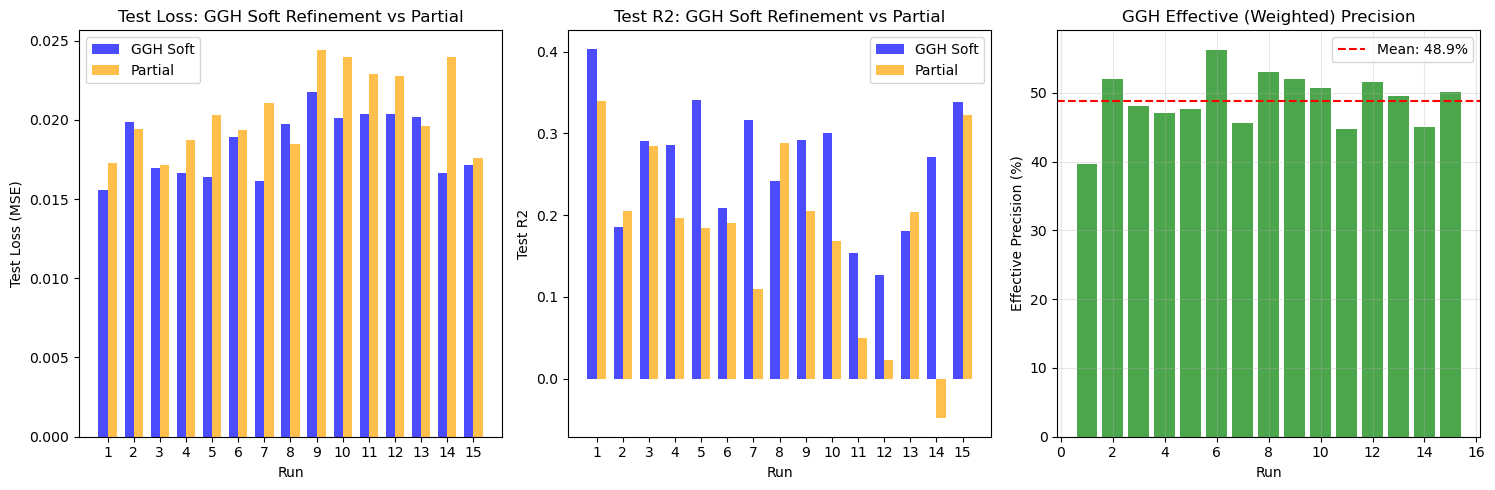


CONCLUSION
GGH Soft Refinement significantly OUTPERFORMS Partial-only on Loss (p=0.0050)
Average loss improvement: 0.0020 MSE
GGH Soft Refinement significantly OUTPERFORMS Partial-only on R2 (p=0.0064)
Average R2 improvement: 0.0808


In [39]:
# =============================================================================
# BENCHMARK: GGH with Soft Weight Iterative Refinement
# =============================================================================
# GGH Method (Soft Weighting):
#   1. Unbiased training -> enriched scores -> initial soft weights
#   2. Weighted training on ALL samples (different weights) + partial
#   3. Biased rescoring -> multiply weights (iterative refinement)
#   4. Loss-based adjustment -> final weights
#   5. Final model trained with refined weights + dynamic partial
# Key: No hard pruning - all samples retained with varying weights
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

# === CONFIGURATION ===
BENCHMARK_N_RUNS = 15
BENCHMARK_RAND_STATES = [42 + i * 100 for i in range(15)]
BENCHMARK_FINAL_EPOCHS = 200
BENCHMARK_LR = 0.01

# GGH Parameters - Soft Weighting (Iterative Refinement)
GGH_ITER1_EPOCHS = 60              # 60 epochs unbiased
GGH_ITER1_ANALYSIS_EPOCHS = 5      # Last 5 tracked
GGH_ITER1_LR = 0.01                # lr=0.01
GGH_ITER2_EPOCHS = 30              # 30 epochs weighted training
GGH_ITER2_LR = 0.01                # lr=0.01
GGH_SCORING_PASSES = 5             # 5 passes for scoring

# Soft Weighting Parameters
GGH_MIN_WEIGHT = 0.1               # No sample below this weight
GGH_TEMPERATURE_ITER1 = 1.0        # Sharpness of Iter1 weight distribution
GGH_TEMPERATURE_ITER3 = 0.8        # Sharpness of Iter3 weight distribution
GGH_LOSS_INFLUENCE = 0.25          # How much loss affects final weights (0-1)
GGH_PARTIAL_BASE_WEIGHT = 2.0      # Base partial weight

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


# === HELPER FUNCTIONS ===
def sigmoid_stable(x):
    """Numerically stable sigmoid."""
    x = np.array(x, dtype=np.float64)
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

def compute_soft_weights(scores, min_weight=0.1, temperature=1.0):
    """
    Convert scores to soft weights using sigmoid.
    Higher score -> higher weight (approaching 1.0)
    Lower score -> lower weight (approaching min_weight)
    """
    scores = np.array(scores, dtype=np.float64)
    if len(scores) == 0:
        return np.array([])
    
    # Normalize scores
    mean_s = np.mean(scores)
    std_s = np.std(scores) + 1e-8
    normalized = (scores - mean_s) / std_s
    
    # Apply sigmoid with temperature
    raw_weights = sigmoid_stable(normalized / temperature)
    
    # Scale to [min_weight, 1.0]
    weights = min_weight + (1 - min_weight) * raw_weights
    
    return weights


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """Compute enriched score with loss included (gradient + features + loss)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    loss_params = anchor_data.get('loss_norm_params', {}).get(class_id)
    grad_scale = anchor_data.get('grad_scale', 1.0)
    
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    if loss_params:
        loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
    else:
        loss_norm = -loss * grad_scale
    
    enriched = np.concatenate([gradient, features_norm, [loss_norm]])
    
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


# === WEIGHTED TRAINER CLASS ===
class WeightedTrainer:
    """
    Train on ALL samples with continuous weights.
    Replaces binary selection with soft weighting.
    """
    def __init__(self, DO, model, sample_weights, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.sample_weights = sample_weights  # Dict: gid -> weight (0.1 to 1.0)
        self.partial_gids = set(partial_gids)
        self.partial_weight = partial_weight
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch with weighted samples."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Get weights for each sample
            weights = torch.zeros(len(inputs), device=self.device)
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                elif gid in self.sample_weights:
                    weights[i] = self.sample_weights[gid]
                # else: weight stays 0 (not selected)
            
            if weights.sum() == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0


def train_with_soft_weights(DO, model, sample_weights, partial_gids, partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with soft weights and validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = WeightedTrainer(DO, model, sample_weights=sample_weights, 
                             partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


# === MAIN GGH SOFT REFINEMENT FUNCTION ===
def run_ggh_soft_refinement(DO, rand_state):
    """
    GGH with soft weight iterative refinement.
    
    Iter1: Unbiased -> enriched scores -> initial soft weights
    Iter2: Weighted training on ALL selected samples + partial
    Iter3: Biased rescoring -> multiply weights (refine confidence)
    Iter4: Loss-based adjustment -> final weights
    
    Returns: gid_weights, effective_precision, partial_gids, partial_weight_dynamic
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Unbiased training + Initial soft weights ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=GGH_ITER1_LR)
    
    # Train (60 epochs, track last 5)
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    # Compute anchors and analysis
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    # Score all non-partial samples (select best hypothesis per sample)
    sample_scores = {}  # sample_idx -> (score, best_gid, is_correct)
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_gid, best_is_correct = -np.inf, None, False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            sample_scores[sample_idx] = (best_score, best_gid, best_is_correct)
    
    # Convert scores to soft weights
    scores_list = [s[0] for s in sample_scores.values()]
    weights_iter1 = compute_soft_weights(scores_list, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER1)
    
    # Map weights to gids
    gid_weights = {}
    sample_to_gid = {}
    for i, (sample_idx, (score, gid, is_correct)) in enumerate(sample_scores.items()):
        gid_weights[gid] = float(weights_iter1[i])
        sample_to_gid[sample_idx] = gid
    
    # Track stats
    iter1_correct = sum(1 for s in sample_scores.values() if s[2])
    iter1_precision = iter1_correct / len(sample_scores) * 100
    correct_weights = [gid_weights[s[1]] for s in sample_scores.values() if s[2]]
    incorrect_weights = [gid_weights[s[1]] for s in sample_scores.values() if not s[2]]
    avg_weight_correct = np.mean(correct_weights) if correct_weights else 0
    avg_weight_incorrect = np.mean(incorrect_weights) if incorrect_weights else 0
    
    # Track class distribution (weighted)
    iter1_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for sample_idx, (score, gid, is_correct) in sample_scores.items():
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        iter1_class_counts[class_id] += 1
    
    print(f"  Iter1: {len(sample_scores)} samples, precision: {iter1_precision:.1f}%, class dist: {iter1_class_counts}")
    print(f"    Avg weight correct: {avg_weight_correct:.3f}, incorrect: {avg_weight_incorrect:.3f}")
    
    # === ITERATION 2: Weighted training ===
    set_to_deterministic(rand_state + 100)
    model_weighted = HypothesisAmplifyingModel(n_shared, n_hyp,
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                               MODEL_FINAL_HIDDEN, out_size)
    
    trainer_weighted = WeightedTrainer(DO, model_weighted, sample_weights=gid_weights,
                                       partial_gids=partial_correct_gids,
                                       partial_weight=GGH_PARTIAL_BASE_WEIGHT, lr=GGH_ITER2_LR)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_weighted.train_epoch(dataloader, epoch)
    
    # === ITERATION 3: Biased rescoring -> Multiply weights ===
    # Score all selected samples with biased model
    selected_sample_indices = set(sample_scores.keys())
    scorer = RemainingDataScorer(DO, model_weighted, selected_sample_indices | partial_sample_indices)
    scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    biased_analysis = scorer.get_analysis()
    
    # Build biased anchors from partial data
    anchor_data_biased = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
        'loss_norm_params': {},
    }
    
    all_grads = [biased_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_biased['grad_scale'] = grad_scale
    
    inpt_vars_list = DO.inpt_vars
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        correct_losses, incorrect_losses = [], []
        
        for gid in partial_correct_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(biased_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    correct_losses.append(biased_analysis[gid]['avg_loss'])
        
        for gid in blacklisted_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(biased_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    incorrect_losses.append(biased_analysis[gid]['avg_loss'])
        
        if correct_grads and incorrect_grads:
            anchor_data_biased['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_biased['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_biased['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in correct_features]
            incorrect_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in incorrect_features]
            
            all_losses = correct_losses + incorrect_losses
            loss_mean = np.mean(all_losses)
            loss_std = np.std(all_losses) + 1e-8
            anchor_data_biased['loss_norm_params'][class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
            
            correct_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in correct_losses]
            incorrect_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in incorrect_losses]
            
            correct_enriched = [np.concatenate([g, f, [l]]) 
                               for g, f, l in zip(correct_grads, correct_features_norm, correct_losses_norm)]
            incorrect_enriched = [np.concatenate([g, f, [l]]) 
                                 for g, f, l in zip(incorrect_grads, incorrect_features_norm, incorrect_losses_norm)]
            
            anchor_data_biased['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_biased['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    # Compute Iter3 scores for all selected samples
    iter3_scores = {}
    for sample_idx, (_, gid, _) in sample_scores.items():
        if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None:
            gradient = biased_analysis[gid]['avg_gradient']
            loss = biased_analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            score = compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            iter3_scores[gid] = score
    
    # Convert to soft weights and multiply with Iter1 weights
    scores_list_iter3 = list(iter3_scores.values())
    gids_iter3 = list(iter3_scores.keys())
    weights_iter3_raw = compute_soft_weights(scores_list_iter3, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER3)
    
    for i, gid in enumerate(gids_iter3):
        gid_weights[gid] = gid_weights[gid] * weights_iter3_raw[i]
    
    # Renormalize to [MIN_WEIGHT, 1.0]
    if gid_weights:
        max_w = max(gid_weights.values())
        if max_w > 0:
            for gid in gid_weights:
                gid_weights[gid] = GGH_MIN_WEIGHT + (gid_weights[gid] / max_w) * (1 - GGH_MIN_WEIGHT)
    
    correct_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_iter3 = np.mean(correct_weights_iter3) if correct_weights_iter3 else 0
    avg_weight_incorrect_iter3 = np.mean(incorrect_weights_iter3) if incorrect_weights_iter3 else 0
    print(f"  Iter3 (after multiply): Avg weight correct: {avg_weight_correct_iter3:.3f}, incorrect: {avg_weight_incorrect_iter3:.3f}")
    
    # === ITERATION 4: Loss-based adjustment ===
    losses = {gid: biased_analysis[gid]['avg_loss']
              for gid in gid_weights if gid in biased_analysis}
    
    if losses:
        loss_values = list(losses.values())
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values) + 1e-8
        
        for gid in gid_weights:
            if gid in losses:
                norm_loss = (losses[gid] - loss_mean) / loss_std
                # Higher loss -> lower weight (but never below MIN_WEIGHT)
                loss_factor = 1 - GGH_LOSS_INFLUENCE * sigmoid_stable(norm_loss)
                gid_weights[gid] = max(GGH_MIN_WEIGHT, gid_weights[gid] * loss_factor)
    
    correct_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_final = np.mean(correct_weights_final) if correct_weights_final else 0
    avg_weight_incorrect_final = np.mean(incorrect_weights_final) if incorrect_weights_final else 0
    print(f"  Iter4 (after loss adj): Avg weight correct: {avg_weight_correct_final:.3f}, incorrect: {avg_weight_incorrect_final:.3f}")
    
    # === Compute effective precision (weighted) ===
    total_weight_correct = sum(correct_weights_final)
    total_weight_all = sum(gid_weights.values())
    effective_precision = total_weight_correct / total_weight_all * 100 if total_weight_all > 0 else 0
    
    # Also compute unweighted precision for comparison
    unweighted_correct = len(correct_weights_final)
    unweighted_total = len(gid_weights)
    unweighted_precision = unweighted_correct / unweighted_total * 100 if unweighted_total > 0 else 0
    
    print(f"  Unweighted precision: {unweighted_precision:.1f}%, Effective (weighted) precision: {effective_precision:.1f}%")
    
    # === Dynamic partial weight ===
    # Lower average weight -> higher partial weight (more uncertainty -> lean on anchor)
    avg_final_weight = np.mean(list(gid_weights.values())) if gid_weights else 0.5
    partial_weight_dynamic = GGH_PARTIAL_BASE_WEIGHT * (1 + (1 - avg_final_weight))
    print(f"  Dynamic partial_weight: {partial_weight_dynamic:.2f}")
    
    return gid_weights, effective_precision, partial_correct_gids, partial_weight_dynamic


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("BENCHMARK: GGH Soft Weight Refinement vs Partial-Only")
print("=" * 80)
print("GGH Method (Soft Weighting - No Hard Pruning):")
print(f"  Iter1: {GGH_ITER1_EPOCHS} epochs unbiased (lr={GGH_ITER1_LR}), last {GGH_ITER1_ANALYSIS_EPOCHS} tracked")
print(f"  Iter1: Enriched scoring -> soft weights (min={GGH_MIN_WEIGHT}, temp={GGH_TEMPERATURE_ITER1})")
print(f"  Iter2: {GGH_ITER2_EPOCHS} epochs weighted training (lr={GGH_ITER2_LR}, pw={GGH_PARTIAL_BASE_WEIGHT})")
print(f"  Iter3: Biased rescoring -> multiply weights (temp={GGH_TEMPERATURE_ITER3})")
print(f"  Iter4: Loss-based adjustment (influence={GGH_LOSS_INFLUENCE})")
print(f"  Final: Train with refined weights + dynamic partial")
print(f"Partial: Train only on partial data (~2.5%)")
print(f"Both: {BENCHMARK_FINAL_EPOCHS} epochs, validation-based epoch selection, same architecture")
print("=" * 80)

results = []

for run_idx, run_rand_state in enumerate(BENCHMARK_RAND_STATES):
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # Setup DataOperator
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get partial data
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_shared = len(DO_run.inpt_vars)
    n_hyp = len(DO_run.miss_vars)
    out_size = len(DO_run.target_vars)
    
    # === Run GGH Soft Refinement ===
    print("Running GGH Soft Refinement...")
    gid_weights, ggh_precision, _, partial_weight_dynamic = run_ggh_soft_refinement(DO_run, run_rand_state)
    
    # === Train GGH final model with soft weights ===
    print(f"Training GGH model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_soft_weights(
        DO_run, model_ggh, sample_weights=gid_weights, partial_gids=partial_gids,
        partial_weight=partial_weight_dynamic, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, "
          f"test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model ===
    print(f"Training Partial model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                              MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_partial, partial_best_epoch, partial_best_val_loss = train_with_soft_weights(
        DO_run, model_partial, sample_weights={}, partial_gids=partial_gids,
        partial_weight=1.0, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, "
          f"test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    results.append({
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_loss': partial_test_loss - ggh_test_loss,
        'improvement_mae': partial_test_mae - ggh_test_mae,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, "
          f"MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")


# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: GGH Soft Weight Refinement vs Partial-Only")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'Eff Prec':<10} {'GGH Loss':<12} {'Part Loss':<12} {'Δ Loss':<10} {'GGH R2':<10} {'Part R2':<10} {'Δ R2':<10}")
print("-" * 100)
for i, r in enumerate(results):
    print(f"{i+1:<5} {r['ggh_precision']:<10.1f}% {r['ggh_test_loss']:<12.4f} {r['partial_test_loss']:<12.4f} "
          f"{r['improvement_loss']:+10.4f} {r['ggh_test_r2']:<10.4f} {r['partial_test_r2']:<10.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_precisions = [r['ggh_precision'] for r in results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nGGH Effective Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"\nTest Loss (MSE):")
print(f"  GGH:     {np.mean(ggh_losses):.4f} ± {np.std(ggh_losses):.4f}")
print(f"  Partial: {np.mean(partial_losses):.4f} ± {np.std(partial_losses):.4f}")
print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s):.4f} ± {np.std(partial_r2s):.4f}")

# Statistical tests
t_stat_loss, p_value_loss = stats.ttest_rel(ggh_losses, partial_losses)
t_stat_r2, p_value_r2 = stats.ttest_rel(ggh_r2s, partial_r2s)

print(f"\nStatistical Tests (paired t-test):")
print(f"  Loss: t={t_stat_loss:.3f}, p={p_value_loss:.4f} {'*' if p_value_loss < 0.05 else ''}")
print(f"  R2:   t={t_stat_r2:.3f}, p={p_value_r2:.4f} {'*' if p_value_r2 < 0.05 else ''}")

# Win/Loss count
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])
n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{BENCHMARK_N_RUNS} ({n_ggh_wins_loss/BENCHMARK_N_RUNS*100:.1f}%)")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{BENCHMARK_N_RUNS} ({n_ggh_wins_r2/BENCHMARK_N_RUNS*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

# Plot 1: Test Loss comparison
ax1 = axes[0]
ax1.bar(x - width/2, ggh_losses, width, label='GGH Soft', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_losses, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test Loss (MSE)')
ax1.set_title('Test Loss: GGH Soft Refinement vs Partial')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 2: R2 comparison
ax2 = axes[1]
ax2.bar(x - width/2, ggh_r2s, width, label='GGH Soft', color='blue', alpha=0.7)
ax2.bar(x + width/2, partial_r2s, width, label='Partial', color='orange', alpha=0.7)
ax2.set_xlabel('Run')
ax2.set_ylabel('Test R2')
ax2.set_title('Test R2: GGH Soft Refinement vs Partial')
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 3: GGH Effective Precision across runs
ax3 = axes[2]
ax3.bar(range(1, BENCHMARK_N_RUNS+1), ggh_precisions, color='green', alpha=0.7)
ax3.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax3.set_xlabel('Run')
ax3.set_ylabel('Effective Precision (%)')
ax3.set_title('GGH Effective (Weighted) Precision')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_soft_refinement_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement_loss = np.mean([r['improvement_loss'] for r in results])
avg_improvement_r2 = np.mean([r['improvement_r2'] for r in results])
if avg_improvement_loss > 0 and p_value_loss < 0.05:
    print(f"GGH Soft Refinement significantly OUTPERFORMS Partial-only on Loss (p={p_value_loss:.4f})")
    print(f"Average loss improvement: {avg_improvement_loss:.4f} MSE")
elif avg_improvement_loss < 0 and p_value_loss < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Soft Refinement on Loss (p={p_value_loss:.4f})")
else:
    print(f"No significant difference in Loss (p={p_value_loss:.4f})")

if avg_improvement_r2 > 0 and p_value_r2 < 0.05:
    print(f"GGH Soft Refinement significantly OUTPERFORMS Partial-only on R2 (p={p_value_r2:.4f})")
    print(f"Average R2 improvement: {avg_improvement_r2:.4f}")
elif avg_improvement_r2 < 0 and p_value_r2 < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Soft Refinement on R2 (p={p_value_r2:.4f})")
else:
    print(f"No significant difference in R2 (p={p_value_r2:.4f})")